<a href="https://colab.research.google.com/github/AnnaVitali/plantRecognition/blob/develop/plantRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download training set

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Saving kaggle.json to kaggle.json
ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                        480KB  2023-01-04 12:50:31           5105        179  1.0              
senapatirajesh/netflix-tv-shows-and-movies                      Latest Netflix TV shows and movies                  1MB  2023-01-14 17:03:12           1522         48  0.9411765        
johnny1994/divorce-rates-data-should-you-get-married            Divorce Rates Data: Should You Get Married?        22KB  2023-01-15 12:49:06            849         32  0.88235295       
rakkesharv/spotify-top-10000-streame

In [2]:
! unzip new-plant-diseases-dataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New P

In [4]:
!apt-get install nvidia-cuda-toolkit
!pip3 install numba

import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/lib/nvidia-cuda-toolkit/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/lib/x86_64-linux-gnu/libnvvm.so"

from numba import cuda

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cpp-8 fonts-dejavu-core fonts-dejavu-extra g++-8 gcc-8 gcc-8-base
  javascript-common libaccinj64-10.1 libatk-wrapper-java
  libatk-wrapper-java-jni libcublas10 libcublaslt10 libcudart10.1 libcufft10
  libcufftw10 libcuinj64-10.1 libcupti-dev libcupti-doc libcupti10.1
  libcurand10 libcusolver10 libcusolvermg10 libcusparse10 libgail-common
  libgail18 libgcc-8-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libjs-jquery libjs-underscore libmpx2 libncurses5 libnppc10 libnppial10
  libnppicc10 libnppicom10 libnppidei10 libnppif10 libnppig10 libnppim10
  libnppist10 libnppisu10 libnppitc10 libnpps10 libnvblas10 libnvgraph10
  libnvidia-ml-dev libnvjpeg10 libnvrtc10.1 libnvtoolsext1 libnvvm3
  libstdc++-8-dev libthrust-dev libvdpau-dev libxxf86dga1 node-html5shiv
  nsight-compute nsight-systems nvidia-cuda-dev nvidia-cuda-doc
  nvidia-cuda-

## Import

In [7]:
import os
import glob
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import interact, fixed
import ipywidgets as widgets

## Utilities

In [43]:
class_names = ['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper,', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']

def load_data(data_folder_path):
    image_list=[]
    label_list=[]
    class_folder_path_list=glob.glob(data_folder_path+'/*/')
    for class_folder_path in class_folder_path_list:
        class_folder_path=class_folder_path.replace('\\','/')
        folder_label=os.path.basename(class_folder_path.split("_")[0])

        for image_file_path in glob.glob(class_folder_path+'/*'):
            image_file_path=image_file_path.replace('\\','/')
            image=Image.open(image_file_path)
            image = np.asarray(image)[:,:,:3]
            image = cv2.resize(image, (64, 64), interpolation = cv2.INTER_LINEAR)
            image_list.append(image)
            label_list.append(class_names.index(folder_label))

    return np.asarray(image_list),np.asarray(label_list)


def show_images(index, images):
  rows = 5
  columns = 10
  plt.rcParams.update({'font.size': 20})
  _, axs = plt.subplots(rows, columns, squeeze=False, figsize=(20, 10))

  for i in range(rows*columns):
    r = i // columns
    c = i % columns
    axs[r, c].axis('off')
    axs[r, c].imshow(images[i])
    axs[r, c].set_title(class_names[train_y[index[i]]], fontsize = 16)


## Caricamento dataset

In [10]:
db_path_train = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
db_path_valid = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

train_x, train_y = load_data(db_path_train)
valid_x, valid_y = load_data(db_path_valid)


print('Shape training set: {}'.format(train_x.shape))
print('Shape validation set: {}'.format(valid_x.shape))

Shape training set: (70295, 64, 64, 3)
Shape validation set: (17572, 64, 64, 3)


## Visualizzazione immagini

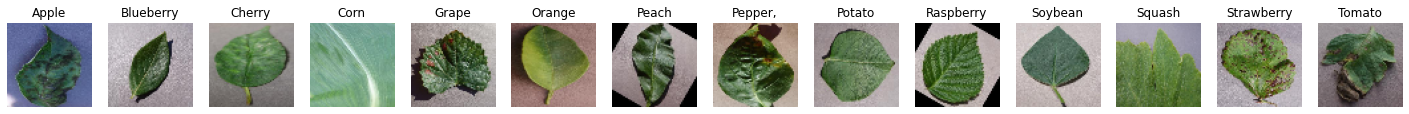

In [6]:
_, axs = plt.subplots(1, len(class_names),figsize=(25, 25))
for i in range(len(class_names)):
  train_class_pos=np.where(train_y==i)
  rnd_idx=random.randint(0,len(train_class_pos[0]))
  p=train_class_pos[0][rnd_idx]
  axs[i].imshow(train_x[p]),axs[i].axis('off'),axs[i].set_title(class_names[train_y[p]])

## Estrazione delle feature

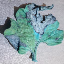

Tomato


In [11]:
image_to_retrieve = 50
i = random.randint(0,len(valid_x))
query = valid_x[i]

cv2_imshow(query)
print(class_names[valid_y[i]])

### Feature di forma

In [ ]:
w_h_range=widgets.IntRangeSlider(description='Range H:',min=0,max=255,value=(0,255), step=1,continuous_update=False)
w_s_range=widgets.IntRangeSlider(description='Range S:',min=0,max=255,value=(0,255), step=1,continuous_update=False)
w_v_range=widgets.IntRangeSlider(description='Range V:',min=0,max=255,value=(0,255), step=1,continuous_update=False)

hsv = cv2.cvtColor(query,cv2.COLOR_BGR2HSV)
@interact(hsv=fixed(hsv),h_range=w_h_range,s_range=w_s_range,v_range=w_v_range)
def interactive_masked_roi(hsv, h_range,s_range,v_range):
  mask = cv2.inRange(hsv, (h_range[0],s_range[0],v_range[0]), (h_range[1],s_range[1],v_range[1]))
  cv2_imshow(mask)

interactive(children=(IntRangeSlider(value=(0, 255), continuous_update=False, description='Range H:', max=255)…

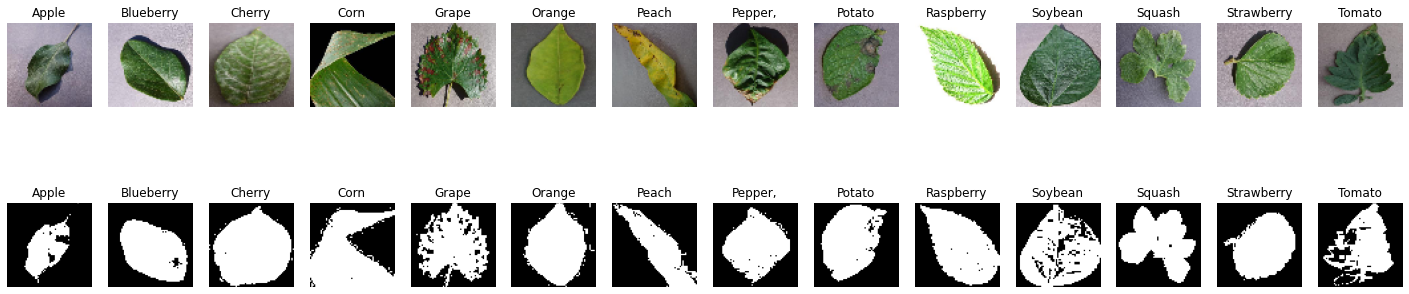

In [9]:
_, axs = plt.subplots(2, len(class_names),figsize=(25, 25))
plt.subplots_adjust(bottom=0.5, top=0.7, hspace=0)
for i in range(len(class_names)):
  train_class_pos=np.where(train_y==i)
  rnd_idx=random.randint(0,len(train_class_pos[0]))
  p=train_class_pos[0][rnd_idx]
  img = train_x[p]

  
  # convert to hsv
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

  # threshold using inRange
  h_min_value=49  #w_h_range.value[0]
  h_max_value=104 #w_h_range.value[1]
  s_min_value=19 #w_s_range.value[0]
  s_max_value=255 #w_s_range.value[1]
  v_min_value=0 #w_v_range.value[0]
  v_max_value=255 #w_v_range.value[1]

  lower_bound = np.array([h_min_value, s_min_value, v_min_value])
  upper_bound = np.array([h_max_value, s_max_value, v_max_value])

  mask = cv2.inRange(hsv,lower_bound,upper_bound)
  sm = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((1,1), np.uint8))
 
  axs[0,i].imshow(img, cmap='gray'),axs[0, i].axis('off'),axs[0, i].set_title(class_names[train_y[p]])
  axs[1,i].imshow(sm, cmap='gray'),axs[1, i].axis('off'),axs[1, i].set_title(class_names[train_y[p]])

In [47]:
from tensorflow.python.ops.gen_data_flow_ops import barrier_close_eager_fallback
def compute_shape_features(img):
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

  # threshold using inRange
  h_min_value=49  
  h_max_value=104 
  s_min_value=19 
  s_max_value=255 
  v_min_value=0 
  v_max_value=255 

  lower_bound = np.array([h_min_value, s_min_value, v_min_value])
  upper_bound = np.array([h_max_value, s_max_value, v_max_value])

  mask = cv2.inRange(hsv,lower_bound,upper_bound)
  sm = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((1,1), np.uint8))
  return sm.flatten()

def compute_shape_feature_similarities(f1, f2):
  return np.minimum(f1, f2).sum() / np.maximum(f1, f2).sum()

def compute_shape_ranking(db_features, query_feature_vector):
  similarities =[compute_shape_feature_similarities(db_feature_vector, query_feature_vector) for db_feature_vector in db_features]
  sorted_idx = np.array(similarities).argsort()[::-1]
  return sorted_idx


#### Risulati feature di forma

In [48]:
train_shape_features = [compute_shape_features(img) for img in tqdm(train_x)]
query_shape_features = compute_shape_features(query)
shape_ranking = compute_shape_ranking(train_shape_features, query_shape_features)
shape_result = [train_x[i] for i in shape_ranking]

  0%|          | 0/70295 [00:00<?, ?it/s]

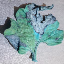

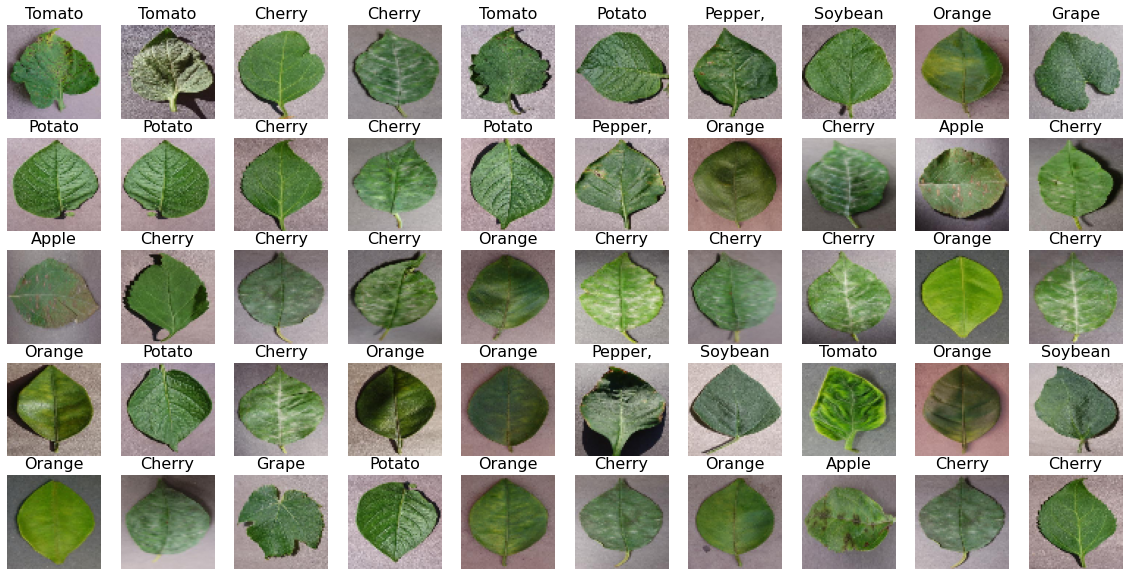

In [45]:
cv2_imshow(query)
print(" ")
show_images(shape_ranking, shape_result[:image_to_retrieve])

## Texture

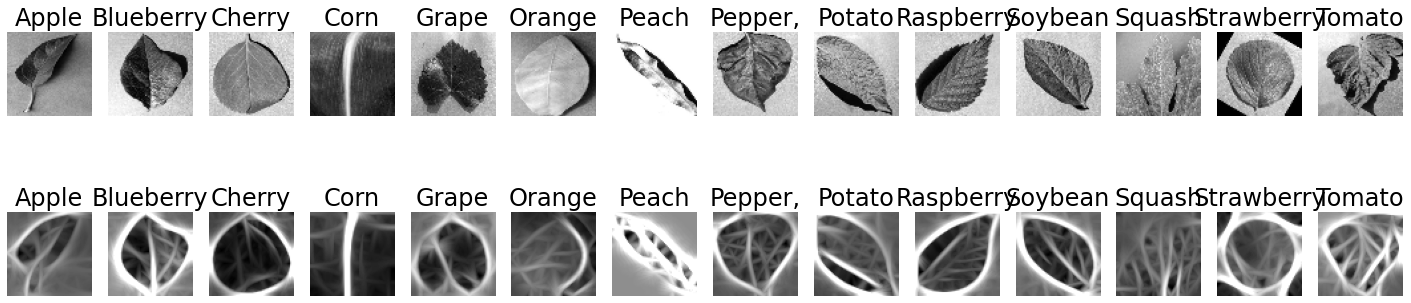

In [52]:
_, axs = plt.subplots(2, len(class_names),figsize=(25, 25))
plt.subplots_adjust(bottom=0.5, top=0.7, hspace=0)

filters = []
ksize = 31
for theta in np.arange(0, np.pi, np.pi / 16):
  kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
  kern /= 1.5 * kern.sum()
  filters.append(kern)

for i in range(len(class_names)):
  train_class_pos=np.where(train_y==i)
  rnd_idx=random.randint(0,len(train_class_pos[0]))
  p=train_class_pos[0][rnd_idx]
  img = train_x[p]
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  accum = np.zeros_like(gray_img)
  for kern in filters:
    fimg = cv2.filter2D(gray_img, cv2.CV_8UC3, kern)
    np.maximum(accum, fimg, accum)
 
  axs[0,i].imshow(gray_img, cmap='gray'),axs[0, i].axis('off'),axs[0, i].set_title(class_names[train_y[p]])
  axs[1,i].imshow(accum, cmap='gray'),axs[1, i].axis('off'),axs[1, i].set_title(class_names[train_y[p]])

In [38]:
def build_filters():
 filters = []
 ksize = 31
 for theta in np.arange(0, np.pi, np.pi / 16):
  kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
  kern /= 1.5 * kern.sum()
  filters.append(kern)
 return filters
 
def process(img, filters):
 accum = np.zeros_like(img)
 for kern in filters:
  fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
  np.maximum(accum, fimg, accum)
 return accum

def compute_texture_feature_similarities(f1, f2):
  return np.minimum(f1, f2).sum()

def compute_texture_ranking(db_feature, query_feature_vector):
  similarities =[compute_texture_feature_similarities(db_feature_vector, query_feature_vector) for db_feature_vector in db_feature]
  sorted_idx = np.array(similarities).argsort()[::-1]
  return sorted_idx

### Risultati texture

In [36]:
training_img_list = [file for file in glob.glob(os.path.join(db_path_train + "/*/*"))]
train_gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_x]
filters = build_filters()
train_texture_features = [process(img, filters) for img in tqdm(train_gray_images)]
query_texture_features = process(cv2.cvtColor(query, cv2.COLOR_BGR2GRAY), filters)
texture_ranking = compute_texture_ranking(train_texture_features, query_texture_features)
texture_result = [train_x[i] for i in texture_ranking]


  0%|          | 0/70295 [00:00<?, ?it/s]

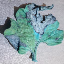

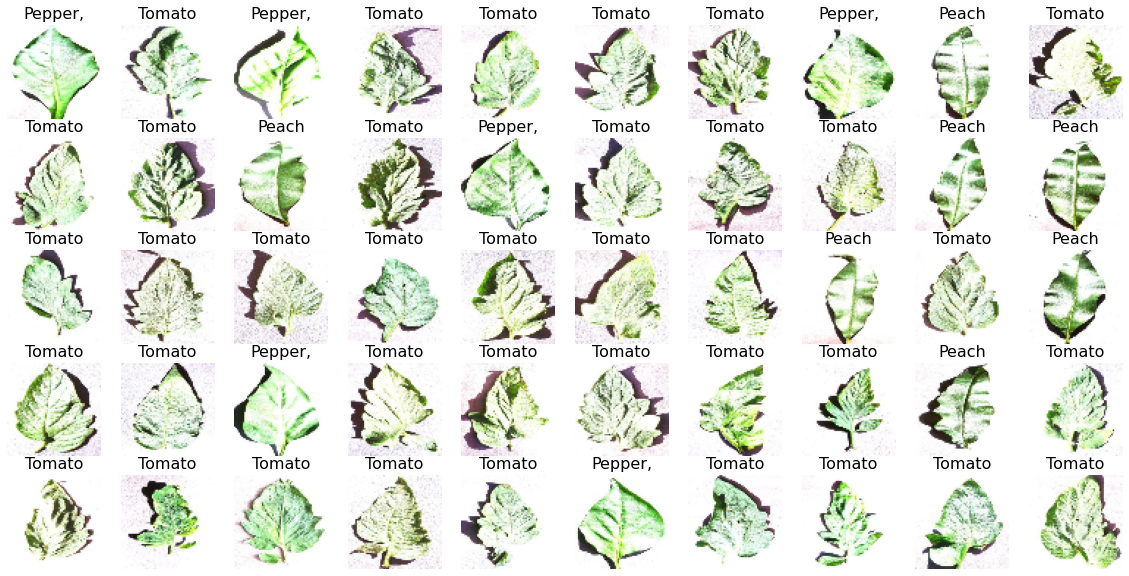

In [46]:
cv2_imshow(query)
print(" ")
show_images(texture_ranking, texture_result[:image_to_retrieve])

## Feature Colore

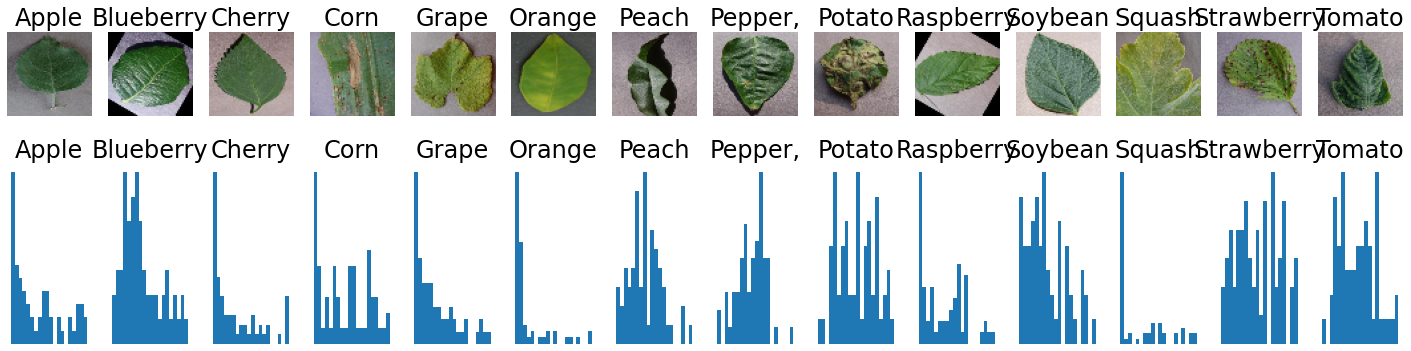

In [81]:
_, axs = plt.subplots(2, len(class_names),figsize=(25, 25))
plt.subplots_adjust(bottom=0.5, top=0.7, hspace=0)


for i in range(len(class_names)):
  train_class_pos=np.where(train_y==i)
  rnd_idx=random.randint(0,len(train_class_pos[0]))
  p=train_class_pos[0][rnd_idx]
  img = train_x[p]
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

  # threshold using inRange
  h_min_value=49  
  h_max_value=104 
  s_min_value=19 
  s_max_value=255 
  v_min_value=0 
  v_max_value=255 

  lower_bound = np.array([h_min_value, s_min_value, v_min_value])
  upper_bound = np.array([h_max_value, s_max_value, v_max_value])

  mask = cv2.inRange(hsv,lower_bound,upper_bound)
  sm = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((1,1), np.uint8))

  bin_count = 20
  s = img.shape
  pixel_count = s[0]*s[1]
  channels = [0,1,2]
  h_range=[h_min_value, h_max_value]
  hists = [cv2.calcHist([img],[c],sm,[bin_count], h_range)/pixel_count for c in channels]
  RGB_hist = np.concatenate((hists[0], hists[1], hists[2]), axis=0)
 
  axs[0,i].imshow(img, cmap='gray'),axs[0, i].axis('off'),axs[0, i].set_title(class_names[train_y[p]])
  axs[1,i].hist(RGB_hist, bins=bin_count),axs[1, i].axis('off'),axs[1, i].set_title(class_names[train_y[p]])
  #axs[1,i].imshow(plt.hist(RGB_hist, bins=bin_count), cmap='gray'),axs[1, i].axis('off'),axs[1, i].set_title(class_names[train_y[p]])

In [82]:
def compute_color_features(img):
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

  # threshold using inRange
  h_min_value=49  
  h_max_value=104 
  s_min_value=19 
  s_max_value=255 
  v_min_value=0 
  v_max_value=255 

  lower_bound = np.array([h_min_value, s_min_value, v_min_value])
  upper_bound = np.array([h_max_value, s_max_value, v_max_value])

  mask = cv2.inRange(hsv,lower_bound,upper_bound)
  sm = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((1,1), np.uint8))

  bin_count = 20
  s = img.shape
  pixel_count = s[0]*s[1]
  channels = [0,1,2]
  h_range=[h_min_value, h_max_value]
  hists = [cv2.calcHist([img],[c],sm,[bin_count], h_range)/pixel_count for c in channels]
  RGB_hist = np.concatenate((hists[0], hists[1], hists[2]), axis=0)
  return RGB_hist

def compute_color_feature_similarities(f1, f2):
  return np.minimum(f1, f2).sum()

def compute_color_ranking(db_features, query_feature_vector):
  similarities =[compute_color_feature_similarities(db_feature_vector, query_feature_vector) for db_feature_vector in db_features]
  sorted_idx = np.array(similarities).argsort()[::-1]
  return sorted_idx

### Risultati feature colore

In [83]:
train_color_features = [compute_color_features(img) for img in tqdm(train_x)]
query_color_features = compute_color_features(query)
color_ranking = compute_color_ranking(train_color_features, query_color_features)
color_result = [train_x[i] for i in color_ranking]

  0%|          | 0/70295 [00:00<?, ?it/s]

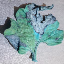

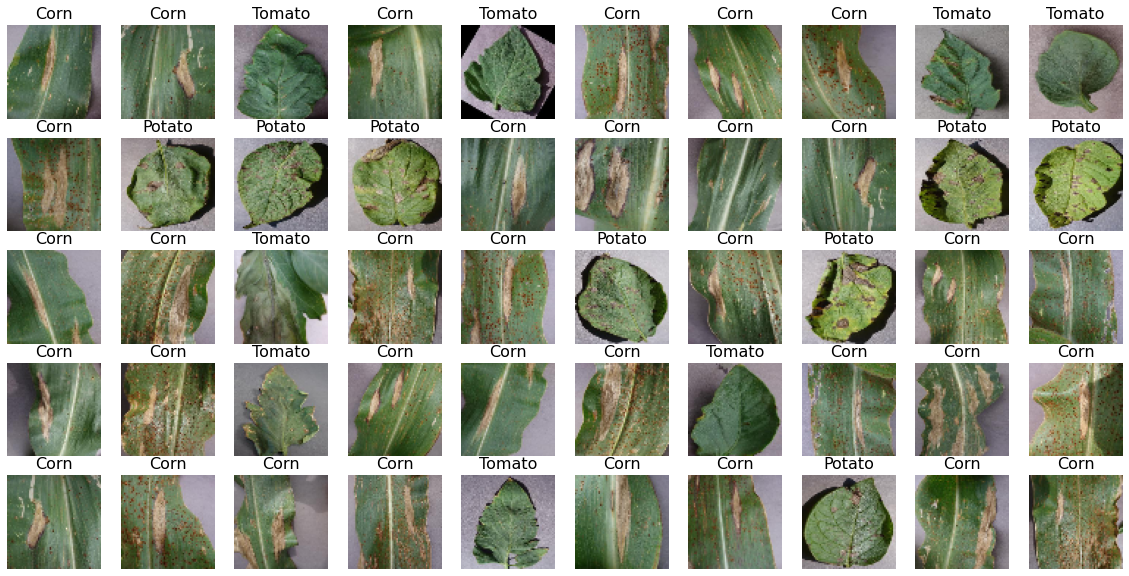

In [84]:
cv2_imshow(query)
print(" ")
show_images(color_ranking, color_result[:image_to_retrieve])

## Classifica finale

In [85]:
def add_scores(scores, ranking, points):
  for i in range(image_to_retrieve):
    scores[ranking[i]] = scores[ranking[i]]+points[i]
  return scores

def borda_count(rankings, weights):
  points = np.arange(image_to_retrieve+1)[::-1][:image_to_retrieve]
  tot_img_scores = np.zeros(len(train_x))
  for i in range(len(rankings)):
    tot_img_scores = add_scores(tot_img_scores, rankings[i], weights[i]*points)
  return tot_img_scores

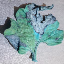

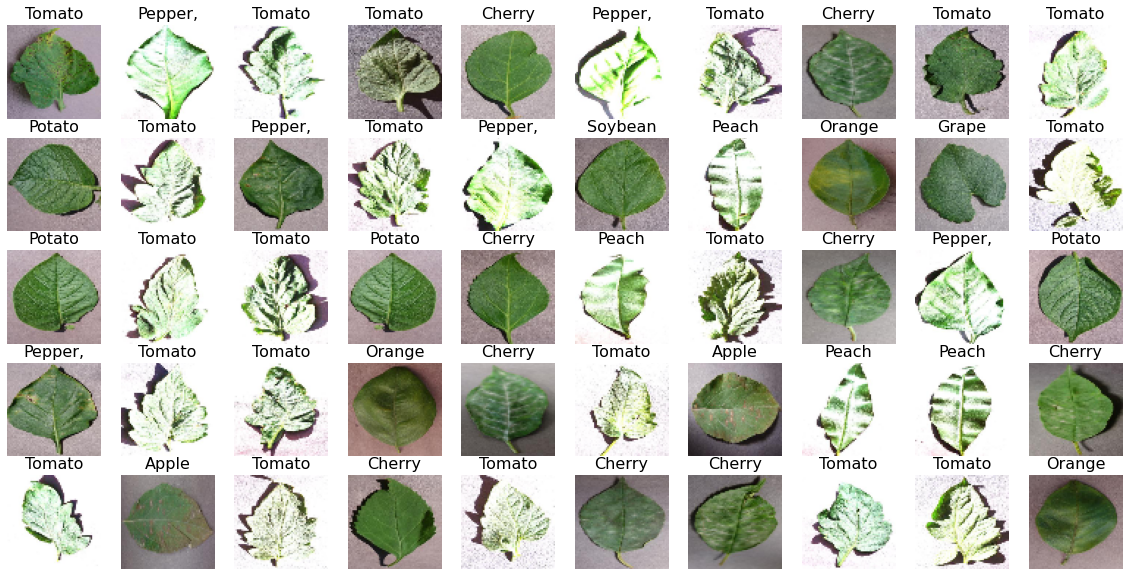

In [89]:
tot_scores = borda_count([color_ranking, shape_ranking, texture_ranking], [0.1, 0.45, 0.45])
tot_ranking = np.array(tot_scores).argsort()[::-1]
result = [train_x[i] for i in tot_ranking]
cv2_imshow(query)
print(" ")
show_images(tot_ranking, result[:image_to_retrieve])

## Addestramento classificatore

In [91]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

In [100]:
clf = SVC()
param_grid = [{'kernel': ['rbf'], 'C': [1.4699], 
               'gamma': [0.0197071], 
               'random_state': [0, 1234]}]
n_folds = 3

# Creazione di un oggetto di tipo GridSearchCV
experiment_gscv = GridSearchCV(clf, param_grid, cv=n_folds, n_jobs=-1)

# Esecuzione della ricerca degli iperparametri 
total_features = np.concatenate((train_color_features, train_shape_features, train_texture_features))

print(total_features.shape)

#experiment_gscv.fit(total_features, train_y)

# Stampa risultati
print('Combinazioni di parametri:\n', experiment_gscv.cv_results_['params'])
print('Accuratezza media per combinazione:\n', experiment_gscv.cv_results_['mean_test_score'])
print('Combinazione migliore:\n', experiment_gscv.best_params_)
print('Accuratezza media della combinazione migliore: %.3f' % experiment_gscv.best_score_)

ValueError: ignored

## Test sul validation set

In [ ]:
validation_shape_features = [compute_shape_features(img) for img in tqdm(valid_x)]

valid_img_list = [file for file in glob.glob(os.path.join(db_path_valid + "/*/*"))]
valid_gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in valid_x]
bow_extractor = train_BOW(valid_img_list)
validation_BOW_features = []
for img in tqdm(valid_gray_images):
  bow_feat = compute_BOW_features(img, bow_extractor)
  if np.any(bow_feat):
    train_BOW_features.append(bow_feat)

valid_color_features = [compute_color_features(img) for img in tqdm(valid_x)]